In [1]:
import numpy as np
from scipy import integrate, linalg, optimize
from matplotlib import pyplot as plt 

def takagi_chen(H):
    # takagi factoriziation part
    sing_vs, Q = linalg.eigh(H)     
    phase_mat = np.diag(
                [np.exp(-1.j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)  
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]  
    Qp = (Qp[:, sort_array])

    return vs, Qp

def takagi_stra(N, tol=1e-13, rounding=13):
    r"""Autonne-Takagi decomposition of a complex symmetric (not Hermitian!) matrix.

    Note that singular values of N are considered equal if they are equal after np.round(values, tol).

    See :cite:`cariolaro2016` and references therein for a derivation.

    Args:
        N (array[complex]): square, symmetric matrix N
        rounding (int): the number of decimal places to use when rounding the singular values of N
        tol (float): the tolerance used when checking if the input matrix is symmetric: :math:`|N-N^T| <` tol

    Returns:
        tuple[array, array]: (rl, U), where rl are the (rounded) singular values,
            and U is the Takagi unitary, such that :math:`N = U \diag(rl) U^T`.
    """
    (n, m) = N.shape
    if n != m:
        raise ValueError("The input matrix must be square")
    if np.linalg.norm(N - np.transpose(N)) >= tol:
        raise ValueError("The input matrix is not symmetric")

    N = np.real_if_close(N)

    if np.allclose(N, 0):
        return np.zeros(n), np.eye(n)

    if np.isrealobj(N):
        # If the matrix N is real one can be more clever and use its eigendecomposition
        l, U = np.linalg.eigh(N)
        vals = np.abs(l)  # These are the Takagi eigenvalues
        phases = np.sqrt(np.complex128([1 if i > 0 else -1 for i in l]))
        Uc = U @ np.diag(phases)  # One needs to readjust the phases
        list_vals = [(vals[i], i) for i in range(len(vals))]
        list_vals.sort(reverse=True)
        sorted_l, permutation = zip(*list_vals)
        permutation = np.array(permutation)
        Uc = Uc[:, permutation]
        # And also rearrange the unitary and values so that they are decreasingly ordered
        return np.array(sorted_l), Uc

    v, l, ws = np.linalg.svd(N)
    w = np.transpose(np.conjugate(ws))
    rl = np.round(l, rounding)

    # Generate list with degenerancies
    result = []
    for k, g in groupby(rl):
        result.append(list(g))

    # Generate lists containing the columns that correspond to degenerancies
    kk = 0
    for k in result:
        for ind, j in enumerate(k):  # pylint: disable=unused-variable
            k[ind] = kk
            kk = kk + 1

    # Generate the lists with the degenerate column subspaces
    vas = []
    was = []
    for i in result:
        vas.append(v[:, i])
        was.append(w[:, i])

    # Generate the matrices qs of the degenerate subspaces
    qs = []
    for i in range(len(result)):
        qs.append(sqrtm(np.transpose(vas[i]) @ was[i]))

    # Construct the Takagi unitary
    qb = block_diag(*qs)

    U = v @ np.conj(qb)
    return rl, U

def psd(npade):
    
    b = np.zeros(2 * npade)
    mat_xi = np.zeros((2 * npade, 2 * npade))
    mat_varsigma = np.zeros((2 * npade - 1, 2 * npade - 1))
    tilde_eta_ = np.zeros(npade, dtype = complex)         # namely cpcoef in evaluatepara.f90
    pole_ = np.zeros(npade, dtype = complex)              # namely cppole in evaluatepara.f90

    for i in range(2 * npade):
        b[i] = 2 * (i) + 1

    for i in range(2 * npade):
        for j in range(2 * npade):
            if (i == j-1 or i == j+1) :
                mat_xi[i,j] = 1.0 / np.sqrt(b[i] * b[j])

    eigval_xi, eigvec_xi = np.linalg.eig(mat_xi) 
    eigval_xi = np.sort(eigval_xi)
            
    for i in range(2 * npade - 1):
        for j in range(2 * npade -1):
            if (i == j-1 or i == j+1) :
                mat_varsigma[i,j] = 1.0 / np.sqrt(b[i+1] * b[j+1])

    eigval_varsigma, eigvec_varsigma = np.linalg.eig(mat_varsigma)
    eigval_varsigma = np.sort(eigval_varsigma)

    for i in range(npade):
        pole_[i] = (0. + 2.j) / abs(eigval_xi[i])
        eigval_xi[i] = 4.0 / eigval_xi[i]**2
    for i in range(npade-1):
        eigval_varsigma[i] = 4.0 / eigval_varsigma[i]**2

    for i in range(npade):
        tilde_eta_[i] = 0.5 * npade * (2 * npade + 1)
        for j in range(i):
            tilde_eta_[i] = tilde_eta_[i] * (eigval_varsigma[j] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
        for j in range(i+1,npade):
            tilde_eta_[i] = tilde_eta_[i] * (eigval_varsigma[j-1] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
        tilde_eta_[i] = (-1. + 0.j) * tilde_eta_[i]
    
    return pole_, tilde_eta_

def fdt_real(omega, t):
    t = np.array([t], dtype=np.float128)
    if (omega / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.real

def fdt_imag(omega, t):
    t = np.array([t], dtype=np.float128)
    if (omega / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.imag

def Jfermi_exact(omega):
    if (omega / T) <= 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma *  band_center)**2 + band_width**2)\
              / (1.0 + np.exp( omega / T ))
    elif (omega / T) > 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma *  band_center)**2 + band_width**2)\
              / 10e+22
    return fun

def fermi_by_pade(omega):
    result = 0.5
    for j in range(num_pade):
        result = result + tilde_eta[j] / (omega / T + pole[j]) \
                        + tilde_eta[j] / (omega / T - pole[j])
    return result

def J_fit(omega, rate, eta):
    fun = 0
    for i in range(len(rate)):
        fun = fun + eta[i] / (rate[i] + 1.j * omega )
    return fun

def mat_fliter(input_mat,crit=1e-9):
    input_mat_real = input_mat.real
    input_mat_imag = input_mat.imag
    input_mat_real[np.abs(input_mat_real) < crit] = 0
    input_mat_imag[np.abs(input_mat_imag) < crit] = 0
    return input_mat_real + 1.j * input_mat_imag

In [2]:
# the information of calculation paratemers
hbar = 0.658211928
omega_max = 50.0
omega_min = -50.0
omega_sample = 10000 + 1
sigma = 1
omega_plt = np.linspace(omega_min, omega_max, omega_sample)
omega = np.linspace(omega_min, omega_max, omega_sample)

time_max = 400.0
time_min = -400.0
time_sample = 4000 + 1
tt = np.linspace(time_min, time_max, time_sample)

tt_for_corr_min = 0.0
tt_for_corr_max = 10.0
time_sample_for_corr =  1000 + 1
tt_for_corr = np.linspace(tt_for_corr_min, tt_for_corr_max, time_sample_for_corr)

bath_corr_psd = np.zeros(time_sample_for_corr, dtype=complex)
bath_corr_exact = np.zeros(time_sample_for_corr, dtype = complex)
bath_corr_exact_real = np.zeros(time_sample_for_corr)
bath_corr_exact_imag = np.zeros(time_sample_for_corr)

print('Done!')

Done!


In [3]:
# the information of fermi funcaiton
T = 0.01              #eV

# define the fermi function f(w)
fermi = np.zeros(omega_sample)
for i in range(omega_sample):
    if (omega[i] / (T)) <= 50 :
        fermi[i] = 1.0 / ( 1.0 + np.exp( omega[i] / (T) ) )
    elif (omega[i] / (T)) > 50 :
        fermi[i] = 1.0 / 10e+22

In [4]:
# the information of bath spectral funcation J(w)
# the Lorentz type J(w) = 0.5 * sys_bath_coupling * band_width**2 / ( (w + band_center)**2 + band_width**2)
sys_bath_coupling = 0.2  #eV, is equal to HEOM-QUICK
band_width = 2.0         #eV
band_center = 0.0       #eV

# define J(w)
bath_spectral = np.zeros(omega_sample, dtype=complex)
bath_spectral = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - sigma * band_center)**2 + band_width**2)
spectral_diss_rate = (band_width - 1.j * sigma * band_center) / hbar
spectral_eta = 0.5 * sys_bath_coupling * band_width \
                / ( 1.0 + np.exp((sigma * band_center + 1.j * band_width) / T )) / hbar**2

# if J(w) is obtained from realistic denisty of states, instead of a Lorentzian spectra function, please
# 1. calculate C(w) = J(w) * f(w)
# 2. use the Fourier Transform to obtain the time-domain C(t)
# 3. use the Prony fitting scheme to unravel C(t)

In [ ]:
# thr control parameters of Prony fiting
dimension_Hankel = 3000
num_prony = 8
tt_for_prony_min = 0.0
tt_for_prony_max = 120.0

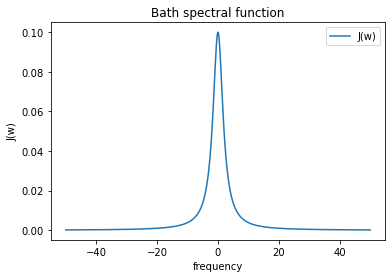

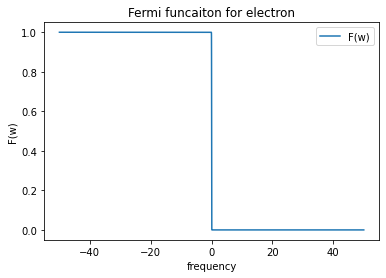

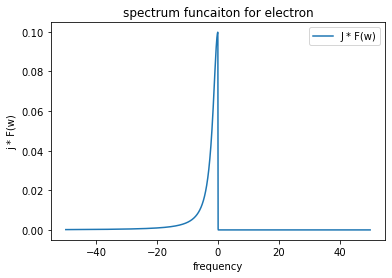

spectral_pole 
 (2+0j)
spectral_eta 
 (0.23081737812298458+0.1355391762938551j)


In [5]:
plt.title("Bath spectral function") 
plt.xlabel("frequency") 
plt.ylabel("J(w)") 
plt.plot(omega_plt, bath_spectral.real, label = 'J(w)')
plt.legend(loc=1)
plt.show()

plt.title("Fermi funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("F(w)") 
plt.plot(omega_plt, fermi.real, label = 'F(w)')
plt.legend(loc=1)
plt.show()

plt.title("spectrum funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("j * F(w)") 
plt.plot(omega_plt, bath_spectral.real * fermi.real, label = 'J * F(w)')
plt.legend(loc=1)
plt.show()


# bath_corr_exact_freq = bath_spectral * fermi

print('spectral_pole \n', spectral_diss_rate * hbar)
print('spectral_eta \n', spectral_eta)


run times / total times: 0 / 10000  =  0.00
run times / total times: 1000 / 10000  =  0.10
run times / total times: 2000 / 10000  =  0.20
run times / total times: 3000 / 10000  =  0.30
run times / total times: 4000 / 10000  =  0.40
run times / total times: 5000 / 10000  =  0.50
run times / total times: 6000 / 10000  =  0.60
run times / total times: 7000 / 10000  =  0.70
run times / total times: 8000 / 10000  =  0.80
run times / total times: 9000 / 10000  =  0.90
run times / total times: 10000 / 10000  =  1.00


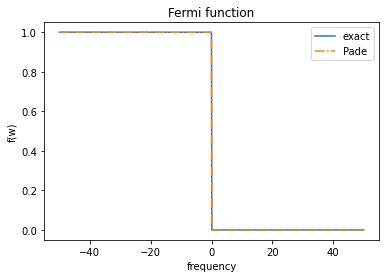

In [6]:
#the Pade scheme
num_pade = 100
tilde_eta = np.zeros(num_pade, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole = np.zeros(num_pade, dtype = complex)              # namely cppole in evaluatepara.f90

pole, tilde_eta = psd(num_pade)

if sigma == -1:
    pole = np.conj(pole)

fermi_pade = np.zeros(omega_sample, dtype = np.complex128)
for i in range(omega_sample):
    fermi_pade[i] = 0.5
    for j in range(num_pade):
        fermi_pade[i] = fermi_pade[i] + tilde_eta[j] / (omega[i] / T + pole[j]) \
                                      + tilde_eta[j] / (omega[i] / T - pole[j])
    if i % 1000 == 0 :
        print("run times / total times:", i ,"/", omega_sample-1, " = ", '%.2f'%(i/(omega_sample-1)))


plt.title("Fermi function") 
plt.xlabel("frequency") 
plt.ylabel("f(w)") 
plt.plot(omega_plt, fermi, label = 'exact')
#plt.plot(omega, fermi_mats.real, label = 'Matsubara', linestyle = '--')
plt.plot(omega_plt, fermi_pade.real, label = 'Pade', linestyle = '-.')
plt.legend(loc=1)
plt.show()

In [7]:
# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade = np.zeros(num_pade + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade = np.zeros(num_pade + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

spectral_diss_rate_pade = (band_width - sigma * 1.j * band_center) / hbar
spectral_eta_pade = (0.5 * sys_bath_coupling) * band_width \
                   * fermi_by_pade((1.j * spectral_diss_rate ) * hbar) / hbar**2

diss_rate_pade[0] = spectral_diss_rate_pade
eta_pade[0] = spectral_eta_pade

for i in range(1, num_pade + 1):
    diss_rate_pade[i] = (-1.j * sigma * T * pole[i - 1] ) / hbar
    eta_pade[i] = 2.j * tilde_eta[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2    
    
#print('pade_diss_rate \n', -1 * diss_rate_pade * hbar)
#print('pade_eta \n', eta_pade)
#print('pade_eta * hbar**2 \n', eta_pade * hbar**2)

In [8]:
# compare the pade results and the exact correlation function in time domain
# exact results
j = 0
for i in range(time_sample_for_corr):
    j = j + 1
    bath_corr_exact_real[i],err = integrate.quad(fdt_real, a = -100, b = 100, args=(tt_for_corr[i]), limit = 20000)
    bath_corr_exact_imag[i],err = integrate.quad(fdt_imag, a = -200, b = 200, args=(tt_for_corr[i]), limit = 10000)
    bath_corr_exact[i] = complex(bath_corr_exact_real[i], bath_corr_exact_imag[i])
    if j % 50 == 0 :
        print("run times / total times:", j ,"/", time_sample_for_corr-1, " = ", '%.2f'%(j/(time_sample_for_corr-1)))

print('Done!')

run times / total times: 50 / 1000  =  0.05
run times / total times: 100 / 1000  =  0.10
run times / total times: 150 / 1000  =  0.15
run times / total times: 200 / 1000  =  0.20
run times / total times: 250 / 1000  =  0.25
run times / total times: 300 / 1000  =  0.30
run times / total times: 350 / 1000  =  0.35
run times / total times: 400 / 1000  =  0.40
run times / total times: 450 / 1000  =  0.45
run times / total times: 500 / 1000  =  0.50
run times / total times: 550 / 1000  =  0.55
run times / total times: 600 / 1000  =  0.60
run times / total times: 650 / 1000  =  0.65
run times / total times: 700 / 1000  =  0.70
run times / total times: 750 / 1000  =  0.75
run times / total times: 800 / 1000  =  0.80
run times / total times: 850 / 1000  =  0.85
run times / total times: 900 / 1000  =  0.90
run times / total times: 950 / 1000  =  0.95
run times / total times: 1000 / 1000  =  1.00
Done!


In [9]:
# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade + 1):
        bath_corr_psd[i] = bath_corr_psd[i] + eta_pade[j] * hbar**2 * np.exp(-1 * diss_rate_pade[j] * hbar * tt_for_corr[i])

print('Done!')

Done!


In [10]:
time_sample_for_prony =  2 * dimension_Hankel + 1
tt_for_prony = np.linspace(tt_for_prony_min, tt_for_prony_max, time_sample_for_prony)
hankel_matrix_real = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
hankel_matrix_imag = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
phi_real = np.zeros(time_sample_for_prony)
phi_imag = np.zeros(time_sample_for_prony)

i = 0
for j in range(time_sample_for_prony):
    i = i + 1
    for k in  range(num_pade + 1):
        phi_real[j] = phi_real[j] + np.real(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j])) 
        phi_imag[j] = phi_imag[j] + np.imag(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j]))
    if i % 500 == 0 :
        print("run times / total times:", i ,"/", time_sample_for_prony-1, " = ", '%.2f'%(i/(time_sample_for_prony-1)))

for n in range(dimension_Hankel + 1):
    for m in range(dimension_Hankel + 1):
        hankel_matrix_real[n,m] = phi_real[n + m]
        hankel_matrix_imag[n,m] = phi_imag[n + m]
        
print('Done!')


run times / total times: 500 / 6000  =  0.08
run times / total times: 1000 / 6000  =  0.17
run times / total times: 1500 / 6000  =  0.25
run times / total times: 2000 / 6000  =  0.33
run times / total times: 2500 / 6000  =  0.42
run times / total times: 3000 / 6000  =  0.50
run times / total times: 3500 / 6000  =  0.58
run times / total times: 4000 / 6000  =  0.67
run times / total times: 4500 / 6000  =  0.75
run times / total times: 5000 / 6000  =  0.83
run times / total times: 5500 / 6000  =  0.92
run times / total times: 6000 / 6000  =  1.00
Done!


In [11]:
sigma_real, U_real = takagi_chen(hankel_matrix_real)
sigma_imag, U_imag = takagi_chen(hankel_matrix_imag)

print(
    "error of decompose real part\n",
    np.sum(np.abs(hankel_matrix_real - np.dot(np.dot(U_real, np.diag(sigma_real)), U_real.T))), "\n"
    "error of decompose imag part\n",
    np.sum(np.abs(hankel_matrix_imag - np.dot(np.dot(U_imag, np.diag(sigma_imag)), U_imag.T))))

print('Done!')

error of decompose real part
 2.2244319505421775e-14 
error of decompose imag part
 5.586204476179438e-12
Done!


In [12]:
prony_roots_real = np.roots(U_real[:, num_prony][::-1])
tmp_index_real = prony_roots_real != 0
prony_roots_real = prony_roots_real[tmp_index_real]
prony_roots_real_new = prony_roots_real[np.argsort(np.abs(prony_roots_real))[:num_prony]]

print('Done!')

Done!


In [13]:
prony_roots_imag = np.roots(U_imag[:, num_prony][::-1])
tmp_index_imag = prony_roots_imag != 0
prony_roots_imag = prony_roots_imag[tmp_index_imag]
prony_roots_imag_new = prony_roots_imag[np.argsort(np.abs(prony_roots_imag))[:num_prony]]
a = np.argsort(np.abs(prony_roots_imag))[:num_prony]

print('Done!')

Done!


In [14]:
omega_matrix_real = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_real[i, j] = prony_roots_real_new[j]**i
eta_prony_real_tmp = np.dot(linalg.inv(np.dot(omega_matrix_real.T, omega_matrix_real)), np.dot(omega_matrix_real.T, phi_real))

omega_matrix_imag = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_imag[i, j] = prony_roots_imag_new[j]**i
eta_prony_imag_tmp = np.dot(linalg.inv(np.dot(omega_matrix_imag.T, omega_matrix_imag)), np.dot(omega_matrix_imag.T, phi_imag))

print('Done!')

Done!


In [15]:
bath_corr_prony = np.zeros(time_sample_for_corr, dtype=complex)

diss_rate_prony_real_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_real_new ) ) + 1.j * np.angle(prony_roots_real_new) )
diss_rate_prony_imag_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_imag_new ) ) + 1.j * np.angle(prony_roots_imag_new) )

eta_prony = np.zeros(2 * num_prony , dtype = complex)
diss_rate_prony = np.zeros(2 * num_prony, dtype = complex)

eta_prony[0:num_prony] = mat_fliter(eta_prony_imag_tmp * 1.j)
eta_prony[num_prony:2 * num_prony] = mat_fliter(eta_prony_real_tmp)

diss_rate_prony[0:num_prony] = mat_fliter(diss_rate_prony_imag_tmp)
diss_rate_prony[num_prony:2*num_prony] = mat_fliter(diss_rate_prony_real_tmp)

for i in range(time_sample_for_corr):
    for j in range(2 * num_prony):
        bath_corr_prony[i] = bath_corr_prony[i] + eta_prony[j] * np.exp(-1 * diss_rate_prony[j] * tt_for_corr[i])

print("diss_rate_prony\n",diss_rate_prony)
print("eta_prony\n",eta_prony)

print('Done!')

diss_rate_prony
 [ 5.38939679e+01  +0.j          1.03976138e+01  +0.j
  3.30824004e+00  +0.j          1.23918006e+00  +0.j
  4.96442691e-01  +0.j          2.08537405e-01  +0.j
  9.58324937e-02  +0.j          3.13567212e-02  +0.j
  6.85366140e+01  +0.j          2.44573911e+01 -63.31467761j
  2.44573911e+01 +63.31467761j  2.40735277e+01+111.04458239j
  2.40735277e+01-111.04458239j  2.00000000e+00  +0.j
 -3.87907883e-01-149.42792805j -3.87907883e-01+149.42792805j]
eta_prony
 [0. +0.00560785j 0. +0.01641348j 0. +0.06304399j 0. -0.06014167j
 0. -0.01505093j 0. -0.00556932j 0. -0.00233285j 0. -0.00199095j
 0. +0.j         0. +0.j         0. +0.j         0. +0.j
 0. +0.j         0.1+0.j         0. +0.j         0. +0.j        ]
Done!


In [16]:
#the Pade scheme
num_pade_small = num_prony * 2
tilde_eta_small = np.zeros(num_pade_small, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole_small = np.zeros(num_pade_small, dtype = complex)              # namely cppole in evaluatepara.f90
bath_corr_psd_small = np.zeros(time_sample_for_corr, dtype = complex)

pole_small, tilde_eta_small = psd(num_pade_small)

if sigma == -1:
    pole_small = np.conj(pole_small)

# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade_small = np.zeros(num_pade_small + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade_small = np.zeros(num_pade_small + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

diss_rate_pade_small[0] = spectral_diss_rate_pade
eta_pade_small[0] = spectral_eta_pade

for i in range(1, num_pade_small + 1):
    diss_rate_pade_small[i] = (-1.j * sigma * T * pole_small[i - 1]) / hbar
    eta_pade_small[i] = 2.j * tilde_eta_small[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole_small[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2    

print('pade_diss_rate \n', -1 * diss_rate_pade_small * hbar)
print('pade_eta \n', eta_pade_small)
print('pade_eta * hbar**2 \n', eta_pade_small * hbar**2)

# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade_small + 1):
        bath_corr_psd_small[i] = bath_corr_psd_small[i] + eta_pade_small[j] * hbar**2 * np.exp(-1 * diss_rate_pade_small[j] * hbar * tt_for_corr[i])

print('Done!')

pade_diss_rate 
 [-2.        +0.j -0.03141593+0.j -0.09424778+0.j -0.15707963+0.j
 -0.21991149+0.j -0.28274334+0.j -0.34557519+0.j -0.40840705+0.j
 -0.47123926+0.j -0.53413196+0.j -0.59900029+0.j -0.67868546+0.j
 -0.79919904+0.j -0.99919622+0.j -1.37139146+0.j -2.25669155+0.j
 -6.72791728+0.j]
pade_eta 
 [0.23081738+0.13553918j 0.        -0.00461749j 0.        -0.00462662j
 0.        -0.004645j   0.        -0.00467284j 0.        -0.00471049j
 0.        -0.00475841j 0.        -0.00481722j 0.        -0.00488786j
 0.        -0.00499179j 0.        -0.00554385j 0.        -0.00790543j
 0.        -0.0132571j  0.        -0.02563397j 0.        -0.07299512j
 0.        +0.39892142j 0.        +0.09568294j]
pade_eta * hbar**2 
 [0.1+0.05872139j 0. -0.00200049j 0. -0.00200445j 0. -0.00201241j
 0. -0.00202448j 0. -0.00204079j 0. -0.00206155j 0. -0.00208703j
 0. -0.00211763j 0. -0.00216266j 0. -0.00240183j 0. -0.00342497j
 0. -0.00574354j 0. -0.01110573j 0. -0.03162462j 0. +0.17282989j
 0. +0.04145396

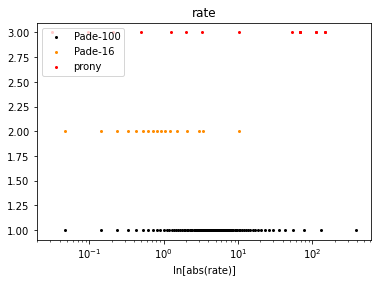

In [17]:
# distribution of poles
one = np.ones(len(diss_rate_pade))
two =  np.ones(len(diss_rate_pade_small)) * 2
three =  np.ones(len(diss_rate_prony)) * 3

plt.title("rate") 
plt.xlabel("ln[abs(rate)]") 
plt.ylabel("") 
plt.scatter(np.abs(diss_rate_pade), one, label = 'Pade-%d' %num_pade, s = 4, color = 'k') 
plt.scatter(np.abs(diss_rate_pade_small), two, label = 'Pade-%d' %num_pade_small, s = 4, color = 'darkorange') 
plt.scatter(np.abs(diss_rate_prony), three, label = 'prony', s = 4, color = 'r') 
plt.legend(loc=2)
plt.xscale("log")
#plt.xlim(-0.1, 1.5)
plt.show()

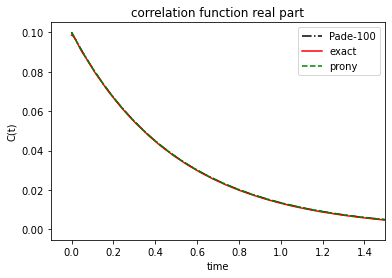

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19]
[0.1        0.09801987 0.09607894 0.09417645 0.09231163 0.09048374
 0.08869204 0.08693582 0.08521438 0.08352702 0.08187308 0.08025188
 0.07866279 0.07710516 0.07557837 0.07408182 0.0726149  0.07117703
 0.06976763 0.06838614]


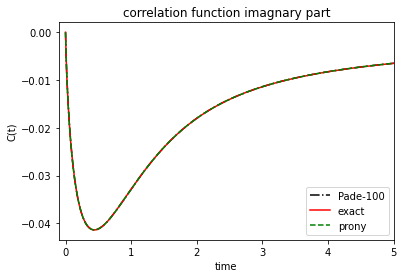

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19]
[ 8.91214186e-17 -5.52682144e-03 -9.27987342e-03 -1.23701708e-02
 -1.50365456e-02 -1.73876224e-02 -1.94890984e-02 -2.13850496e-02
 -2.31069993e-02 -2.46786126e-02 -2.61183345e-02 -2.74409671e-02
 -2.86586658e-02 -2.97815994e-02 -3.08184047e-02 -3.17765118e-02
 -3.26623816e-02 -3.34816851e-02 -3.42394397e-02 -3.49401166e-02]


In [18]:
plt.title("correlation function real part") 
plt.xlabel("time") 
plt.ylabel("C(t)") 
plt.plot(tt_for_corr, bath_corr_psd.real, label = 'Pade-%d' %num_pade, linestyle = '-.', color = 'k') 
plt.scatter(tt_for_corr, bath_corr_psd_small.real, label = 'Pade-%d' %num_pade_small, s = 2, color = 'darkorange') 
plt.plot(tt_for_corr, bath_corr_exact_real / np.pi, label = 'exact', color = 'r') 
plt.plot(tt_for_corr, bath_corr_prony.real, label = 'prony', linestyle = '--', color = 'g')
plt.legend(loc=1)
plt.xlim(-0.1, 1.5)
plt.show()

print(tt_for_corr[:20])
print(bath_corr_psd[:20].real)

plt.title("correlation function imagnary part") 
plt.xlabel("time") 
plt.ylabel("C(t)") 
plt.plot(tt_for_corr, bath_corr_psd.imag, label = 'Pade-%d' %num_pade, linestyle = '-.', color = 'k') 
plt.scatter(tt_for_corr, bath_corr_psd_small.imag, label = 'Pade-%d' %num_pade_small, s = 2, color = 'darkorange') 
plt.plot(tt_for_corr, bath_corr_exact_imag / np.pi, label = 'exact', color = 'r') 
plt.plot(tt_for_corr, bath_corr_prony.imag, label = 'prony', linestyle = '--', color = 'g')
plt.legend(loc=4)
plt.xlim(-0.1, 5)
plt.show()

print(tt_for_corr[:20])
print(bath_corr_psd[:20].imag)

In [19]:
omega_sample_ = omega_sample * 10
omega_max_ = 10
omega_min_ = -10

omega_plt = np.linspace(omega_min_, omega_max_, omega_sample_)

bath_corr_psd_freq = np.zeros(omega_sample_, dtype = complex)
bath_corr_psd_small_freq = np.zeros(omega_sample_, dtype = complex)
bath_corr_prony_freq = np.zeros(omega_sample_, dtype = complex)
bath_corr_exact_freq = np.zeros(omega_sample_, dtype = complex)

fermi_ = np.zeros(omega_sample_)
bath_spectral_ = np.zeros(omega_sample_)
for i in range(omega_sample_):
    if (omega_plt[i] / (T)) <= 50 :
        fermi_[i] = 1.0 / ( 1.0 + np.exp( omega_plt[i] / (T) ) )
    elif (omega_plt[i] / (T)) > 50 :
        fermi_[i] = 1.0 / 10e+22
bath_spectral_ = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega_plt - sigma * band_center)**2 + band_width**2)

bath_corr_exact_freq = bath_spectral_ * fermi_

for i in range(omega_sample_):
    #bath_corr_psd_small_freq[i] = J_fit(omega[i], diss_rate_pade_small * hbar, eta_pade_small * hbar**2)
    bath_corr_psd_freq[i] = J_fit(omega_plt[i], diss_rate_pade * hbar, eta_pade * hbar**2)
    bath_corr_prony_freq[i] = J_fit(omega_plt[i], diss_rate_prony, eta_prony)

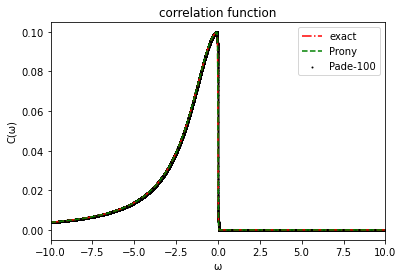

 -9.500244977951985 
 psd   0.004243822244355952 
 exact 0.004243822244355992 
 prony 0.00424530212504326
 small 0.0

 -9.500044995950365 
 psd   0.004243993333725722 
 exact 0.004243993333725761 
 prony 0.0042454735016922394
 small 0.0

 -9.499845013948745 
 psd   0.004244164433289017 
 exact 0.004244164433289059 
 prony 0.004245644888523125
 small 0.0


In [20]:
plt.title("correlation function") 
plt.xlabel("ω") 
plt.ylabel("C(ω)")
plt.scatter(omega_plt, bath_corr_psd_freq.real, label = 'Pade-%d'%num_pade, s = 1, color = 'k')
plt.plot(omega_plt, bath_corr_exact_freq.real, label = 'exact', linestyle = '-.', color = 'r')
plt.plot(omega_plt, bath_corr_prony_freq.real, label = 'Prony', linestyle = '--', color = 'g')
plt.legend(loc=1)
plt.xlim(omega_min_, omega_max_)
#plt.ylim(-0.001, 0.005)
plt.show()

x = 2500
a = max(np.abs(bath_corr_psd_freq.real))
b = max(np.abs(bath_corr_exact_freq.real))
c = max(np.abs(bath_corr_prony_freq.real))
print('',omega_plt[x-1],'\n psd  ',(bath_corr_psd_freq[x-1]).real,'\n exact',bath_corr_exact_freq[x-1],\
      '\n prony',(bath_corr_prony_freq[x-1]).real)
print(' small', bath_corr_psd_small_freq[x-1].real)
print()
print('',omega_plt[x],'\n psd  ',(bath_corr_psd_freq[x]).real,'\n exact',bath_corr_exact_freq[x],\
      '\n prony',(bath_corr_prony_freq[x]).real)
print(' small', bath_corr_psd_small_freq[x].real)
print()
print('',omega_plt[x+1],'\n psd  ',(bath_corr_psd_freq[x+1]).real,'\n exact',bath_corr_exact_freq[x+1],\
      '\n prony',(bath_corr_prony_freq[x+1]).real)
print(' small', bath_corr_psd_small_freq[x+1].real)

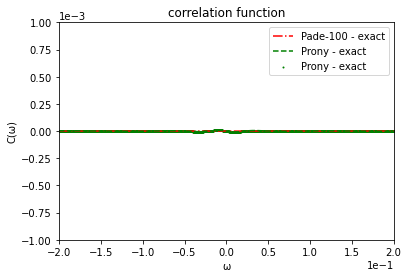

In [21]:
plt.title("correlation function") 
plt.xlabel("ω") 
plt.ylabel("C(ω)")
plt.plot(omega_plt, bath_corr_psd_freq.real - bath_corr_exact_freq.real, label = 'Pade-%d - exact'%num_pade, linestyle = '-.', color = 'r')
plt.plot(omega_plt, bath_corr_prony_freq.real - bath_corr_exact_freq.real, label = 'Prony - exact', linestyle = '--', color = 'g')
plt.scatter(omega_plt, bath_corr_prony_freq.real - bath_corr_exact_freq.real, label = 'Prony - exact', s=1 , color = 'g')
plt.legend(loc=1)
plt.xlim(-0.2, 0.2)
plt.ylim(-0.001, 0.001)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()